# Libraries

In [2]:
import os

# Print out the location/directory of this jupyter notebook file
notebook_path = os.getcwd()
print(notebook_path)

/workspace/Brian2_projects


In [3]:
!pip install brian2

  Using cached Brian2-2.8.0.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.2 kB)
  Using cached numpy-2.2.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
  Using cached Cython-3.0.12-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.3 kB)
  Using cached sympy-1.13.3-py3-none-any.whl.metadata (12 kB)
  Using cached pyparsing-3.2.1-py3-none-any.whl.metadata (5.0 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
Using cached Brian2-2.8.0.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.8 MB)
Using cached Cython-3.0.12-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.5 MB)
Using cached numpy-2.2.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.1 MB)
Using cached sympy-1.13.3-py3-none-any.whl (6.2 MB)
Using cached pyparsing-3.2.1-py3-none-any.whl (107 kB)
Using cached mpmath-1.3.0-py3-none-any.whl (536 kB)


In [4]:
!pip install matplotlib

  Using cached matplotlib-3.10.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Using cached contourpy-1.3.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.56.0-cp312-cp312-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (101 kB)
  Using cached kiwisolver-1.4.8-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.2 kB)
  Using cached pillow-11.1.0-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (9.1 kB)
Using cached matplotlib-3.10.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (8.6 MB)
Using cached contourpy-1.3.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (323 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.56.0-cp312-cp312-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl 

In [5]:
from brian2 import *

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
def visualise_connectivity(S):
    Ns = len(S.source)
    Nt = len(S.target)
    plt.figure(figsize=(10, 4))

    # the left-hand side plot
    plt.subplot(121)
    plt.plot(zeros(Ns), arange(Ns), 'ok', ms=10) # 'ok': circle marker - black; ms: marker size
    plt.plot(ones(Nt), arange(Nt), 'ok', ms=10)
    for i, j in zip(S.i, S.j):
        plt.plot([0, 1], [i, j], '-k') # '-k': solid line - black
    plt.xticks([0, 1], ['Source', 'Target'])
    plt.ylabel('Neuron index')
    plt.xlim(-0.1, 1.1)
    #print()
    plt.ylim(-1, max([Ns,Nt]))
    #plt.ylim(-1, Ns)

    # The right-hand side plot
    plt.subplot(122)
    plt.plot(S.i, S.j, 'ok')
    plt.xlim(-1, Ns)
    plt.ylim(-1, Nt)
    plt.xlabel('Source neuron index')
    plt.ylabel('Target neuron index')

    # save
    plt.savefig('NetworkConnections')

# References

[0] Understanding the homeostasis: Watt, A. J., & Desai, N. S. (2010). Homeostatic plasticity and STDP: keeping a neuron’s cool in a fluctuating world. Frontiers in Synaptic Neuroscience, 2. https://doi.org/10.3389/fnsyn.2010.00005

[1] Homeostasis code: https://brian2.readthedocs.io/en/latest/examples/frompapers.Clopath_et_al_2010_homeostasis.html 

[2] https://brian2.readthedocs.io/en/latest/examples/frompapers.Vogels_et_al_2011.html

[3] Homeostasis integrated in STDP biased towards LTD: Song S, Abbott LF. Cortical development and remapping through spike timing-dependent plasticity. Neuron. 2001 Oct 25;32(2):339-50. doi: 10.1016/s0896-6273(01)00451-2. PMID: 11684002.


# Experiment

## from [1], with comparison to my modification

In [ ]:
start_scope()
################################################################################
# PLASTICITY MODEL
################################################################################

#### Plasticity Parameters

V_rest = -70.*mV        # resting potential
V_thresh = -55.*mV      # spiking threshold
Theta_low = V_rest      # depolarization threshold for plasticity
x_reset = 1.            # spike trace reset value
taux = 15.*ms           # spike trace time constant
A_LTD = 1.5e-4          # depression amplitude
A_LTP = 1.5e-2          # potentiation amplitude
tau_lowpass1 = 40*ms    # timeconstant for low-pass filtered voltage
tau_lowpass2 = 30*ms    # timeconstant for low-pass filtered voltage
tau_homeo = 1000*ms     # homeostatic timeconstant
v_target = 12*mV**2     # target depolarisation

#### Plasticity Equations

# equations executed at every timestepC
Syn_model =   ('''
            w_ampa:1                # synaptic weight (ampa synapse)
            ''')

# equations executed only when a presynaptic spike occurs
Pre_eq = ('''
            g_ampa_post += w_ampa*ampa_max_cond                                                               # increment synaptic conductance
            A_LTD_u = A_LTD*(v_homeo**2/v_target)                                                             # metaplasticity
            w_minus = A_LTD_u*(v_lowpass1_post/mV - Theta_low/mV)*int(v_lowpass1_post/mV - Theta_low/mV > 0)  # synaptic depression
            w_ampa = clip(w_ampa-w_minus, 0, w_max)                                                           # hard bounds
            ''' )

# equations executed only when a postsynaptic spike occurs
Post_eq = ('''
            v_lowpass1 += 10*mV                                                                                        # mimics the depolarisation effect due to a spike
            v_lowpass2 += 10*mV                                                                                        # mimics the depolarisation effect due to a spike
            v_homeo += 0.1*mV                                                                                          # mimics the depolarisation effect due to a spike
            w_plus = A_LTP*x_trace_pre*(v_lowpass2_post/mV - Theta_low/mV)*int(v_lowpass2_post/mV - Theta_low/mV > 0)  # synaptic potentiation
            w_ampa = clip(w_ampa+w_plus, 0, w_max)                                                                     # hard bounds
            ''' )

# My equations executed at every timestepC
Syn_model_m =   ('''
            w_ampa:1                # synaptic weight (ampa synapse)
            dx_trace_prespike/dt = -x_trace_prespike/taux :1  (event-driven)
            ''')

# equations executed only when a presynaptic spike occurs
Pre_eq_m = ('''
            g_ampa_post += w_ampa*ampa_max_cond                                                               # increment synaptic conductance
            A_LTD_u = A_LTD*(v_homeo**2/v_target)                                                             # metaplasticity
            w_minus = A_LTD_u*(v_lowpass1_post/mV - Theta_low/mV)*int(v_lowpass1_post/mV - Theta_low/mV > 0)  # synaptic depression
            w_ampa = clip(w_ampa-w_minus, 0, w_max)                                                           # hard bounds
            x_trace_prespike+=x_reset/(taux/ms)
            ''' )

# equations executed only when a postsynaptic spike occurs
Post_eq_m = ('''
            v_lowpass1 += 10*mV                                                                                        # mimics the depolarisation effect due to a spike
            v_lowpass2 += 10*mV                                                                                        # mimics the depolarisation effect due to a spike
            v_homeo += 0.1*mV                                                                                          # mimics the depolarisation effect due to a spike
            w_plus = A_LTP*x_trace_prespike*(v_lowpass2_post/mV - Theta_low/mV)*int(v_lowpass2_post/mV - Theta_low/mV > 0)  # synaptic potentiation
            w_ampa = clip(w_ampa+w_plus, 0, w_max)                                                                     # hard bounds
            ''' )
################################################################################
# I&F Parameters and equations
################################################################################

#### Neuron parameters

gleak = 30.*nS                  # leak conductance
C = 300.*pF                     # membrane capacitance
tau_AMPA = 2.*ms                # AMPA synaptic timeconstant
E_AMPA = 0.*mV                  # reversal potential AMPA

ampa_max_cond = 5.e-8*siemens  # Ampa maximal conductance
w_max = 1.                      # maximal ampa weight

#### Neuron Equations

# We connect 10 presynaptic neurons to 1 downstream neuron

# downstream neuron
eqs_neurons = '''
dv/dt = (gleak*(V_rest-v) + I_ext + I_syn)/C: volt      # voltage
dv_lowpass1/dt = (v-v_lowpass1)/tau_lowpass1 : volt     # low-pass filter of the voltage
dv_lowpass2/dt = (v-v_lowpass2)/tau_lowpass2 : volt     # low-pass filter of the voltage
dv_homeo/dt = (v-V_rest-v_homeo)/tau_homeo : volt       # low-pass filter of the voltage
I_ext : amp                                             # external current
I_syn = g_ampa*(E_AMPA-v): amp                          # synaptic current
dg_ampa/dt = -g_ampa/tau_AMPA : siemens                 # synaptic conductance
dx_trace/dt = -x_trace/taux :1                          # spike trace
'''

# input neurons
eqs_inputs = '''
dv/dt = gleak*(V_rest-v)/C: volt                        # voltage
dx_trace/dt = -x_trace/taux :1                          # spike trace
rates : Hz                                              # input rates
selected_index : integer (shared)                       # active neuron
'''

################################################################################
# Simulation
################################################################################

#### Parameters

defaultclock.dt = 500.*us                        # timestep
Nr_neurons = 1                                   # Number of downstream neurons
Nr_inputs = 5                                    # Number of input neurons
input_rate = 35*Hz                               # Rates
init_weight = 0.5                                # initial synaptic weight
final_t = 20.*second                             # end of simulation
input_time = 100.*ms                             # duration of an input

#### Create neuron objects

Nrn_downstream = NeuronGroup(Nr_neurons*2, eqs_neurons, threshold='v>V_thresh',
                             reset='v=V_rest;x_trace+=x_reset/(taux/ms)',
                             method='euler')
Nrn_downstream_o = Nrn_downstream[:Nr_neurons]
Nrn_downstream_m = Nrn_downstream[Nr_neurons:]


Nrns_input = NeuronGroup(Nr_inputs, eqs_inputs, threshold='rand()<rates*dt',
                         reset='v=V_rest;x_trace+=x_reset/(taux/ms)',
                         method='exact')

#### create Synapses

Syn = Synapses(Nrns_input, Nrn_downstream_o,
               model=Syn_model,
               on_pre=Pre_eq,
               on_post=Post_eq
               )

Syn.connect(i=numpy.arange(Nr_inputs), j=0)

Syn_m = Synapses(Nrns_input, Nrn_downstream_m,
               model=Syn_model_m,
               on_pre=Pre_eq_m,
               on_post=Post_eq_m
               )

Syn_m.connect(i=numpy.arange(Nr_inputs), j=0)

#### Monitors and storage
W_evolution = StateMonitor(Syn, 'w_ampa', record=True)
W_evolution_m = StateMonitor(Syn_m, 'w_ampa', record=True)

#### Run

# Initial values
Nrn_downstream.v = V_rest
Nrn_downstream.v_lowpass1 = V_rest
Nrn_downstream.v_lowpass2 = V_rest
Nrn_downstream.v_homeo = 0
Nrn_downstream.I_ext = 0.*amp
Nrn_downstream.x_trace = 0.
Nrns_input.v = V_rest
Nrns_input.x_trace = 0.
Syn.w_ampa = init_weight

Syn_m.w_ampa = init_weight

# Switch on a different input every 100ms
Nrns_input.run_regularly('''
                         selected_index = int(floor(rand()*Nr_inputs))
                         rates = input_rate * int(selected_index == i)  # All rates are zero except for the selected neuron
                         ''', dt=input_time)
run(final_t, report='text')

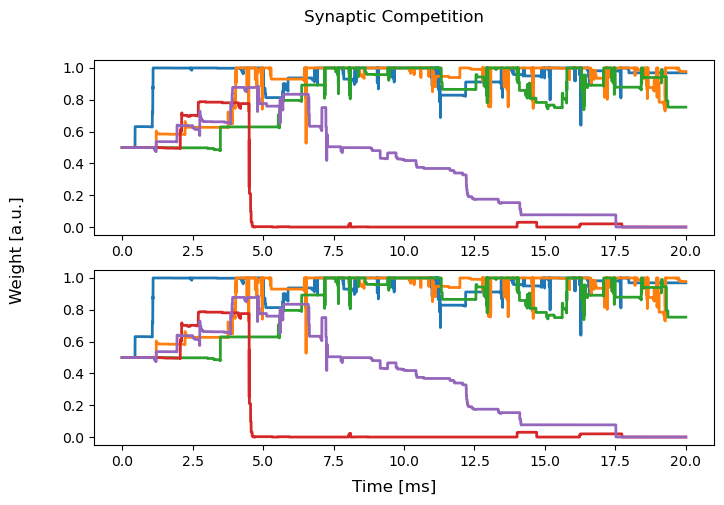

In [8]:
################################################################################
# Plots
################################################################################


fig, axs = plt.subplots(2, figsize=(8, 5)) #sharex=True, sharey=True
fig.suptitle('Synaptic Competition')

for kk in range(Nr_inputs):
    axs[0].plot(W_evolution.t, W_evolution.w_ampa[kk], '-', linewidth=2)
    axs[1].plot(W_evolution_m.t, W_evolution_m.w_ampa[kk], '-', linewidth=2)


fig.supxlabel('Time [ms]', fontsize=12)
fig.supylabel('Weight [a.u.]', fontsize=12)

#subplots_adjust(bottom=0.2, left=0.15, right=0.95, top=0.85)
#title(stitle, fontsize=22)
show()

## case 3: same as case 2, but combine and compare different parameters of stdp, neuron 

### Network

In [8]:
#### Neuron without/with adaptive threshold

start_scope()
defaultclock.dt = 500.*us 

# Poisson input group
N_INP = 20
inp_rates = np.ones(N_INP)* 3 * Hz
pg_inp = PoissonGroup(N_INP, inp_rates, name = 'inp') 


# Excictory group with adaptive threshold

############
##SUB GROUP REF:
##G = NeuronGroup(10, '''dv/dt = -v/tau : volt
##                       tau : second''',
##                threshold='v > -50*mV',
##                reset='v = -70*mV')
# Create subgroups
##G1 = G[:5]
##G2 = G[5:]

# This will set the values in the main group, subgroups are just "views"
##G1.tau = 10*ms
##G2.tau = 20*ms
############


N_NEURONS = 4

v_rest = 0
v_thresh_e = 24e-3
v_inh_base = 0
v_exc_base = 70e-3
v_reset= 10e-3

tau_ge = 5*ms
tau_gi = 5*ms
tau_mem = 50*ms
tc_theta= 1e7 * ms #1e7 * ms # 10 * ms # 1e7 * ms 

tau_lowpass1 = 40*ms    # timeconstant for low-pass filtered voltage
tau_lowpass2 = 30*ms    # timeconstant for low-pass filtered voltage
tau_homeo = 1000*ms     # homeostatic timeconstant

# Gaussian distribution - Brian2 : randn()
# Uniformaly distribution - Brian2 : rand()
refrac_mu, refrac_sigma = 5, 5e-2 # mean and standard deviation
refractor_model = '(5 +  + refrac_sigma*randn())*ms' # 5*ms

eqs = '''
dv/dt = (v_rest-v + i_exc + i_inh)/tau_mem + sigma*xi*tau_mem**-0.5 : 1 (unless refractory)
i_exc = ge   * (v_exc_base -v)            : 1
i_inh = gi   * (v_inh_base - v)           : 1
dge/dt = -ge/ tau_ge                  : 1
dgi/dt = -gi/ tau_gi                  : 1
dtheta/dt = -theta / (tc_theta)         : 1
dtimer/dt = 0.1                           : second
sigma : 1

dv_lowpass1/dt = (v-v_lowpass1)/tau_lowpass1 : 1     # low-pass filter of the voltage
dv_lowpass2/dt = (v-v_lowpass2)/tau_lowpass2 : 1     # low-pass filter of the voltage
dv_homeo/dt = (v-v_rest-v_homeo)/tau_homeo : 1       # low-pass filter of the voltage
'''

# Excictory group with adaptive threshold
theta_plus_e = 0.05
theta_plus_e_mu, theta_plus_ec_sigma = 0, 0.05e-2 # mean and standard deviation

reset = '''
v = v_reset
theta += (theta_plus_e + (theta_plus_e_mu + theta_plus_ec_sigma*randn()))* 1e-3
timer = 0 * ms
'''

threshold_mu, threshold_sigma = 0, (v_thresh_e*1e-2)
# adpt, timer
threshold_adpt_timer = '(v>(theta + v_thresh_e + (threshold_mu + threshold_sigma*randn()))) and (timer>refrac_mu*ms)' # '(v>(theta + v_thresh_e)) and (timer>refractory)'
# adpt, no timer
threshold_adpt = 'v>(theta + v_thresh_e + (threshold_mu + threshold_sigma*randn()))'


ng_exc = NeuronGroup(
    N_NEURONS, eqs, 
    threshold= threshold_adpt_timer, 
    reset=reset, 
    refractory=refractor_model, 
    method='euler',
    name = 'exc')
ng_exc.sigma = 1.2 * (v_thresh_e - v_reset)

# Excictory group without adaptive threshold
reset_no_adthr = '''
v = v_reset
'''
ng_exc_no_adthr = NeuronGroup(
    N_NEURONS, eqs, 
    threshold= threshold_adpt, 
    reset=reset_no_adthr, 
    refractory=refractor_model, 
    method='euler',
    name = 'exc_no_adthr')
ng_exc_no_adthr.sigma = 1.2 * (v_thresh_e - v_reset)

# Excictory group with adaptive threshold, small nosie
ng_exc_sm_noise = NeuronGroup(
    N_NEURONS, eqs, 
    threshold= threshold_adpt_timer,
    reset=reset, 
    refractory=refractor_model, 
    method='euler',
    name = 'exc_sm_noise')
ng_exc_sm_noise.sigma = 0.5 * (v_thresh_e - v_reset)

# Excictory group without adaptive threshold, volt_stdp (vstdp)
ng_exc_no_adthr_vstdp = NeuronGroup(
    N_NEURONS, eqs, 
    threshold= threshold_adpt, 
    reset=reset_no_adthr, 
    refractory=refractor_model, 
    method='euler',
    name = 'exc_no_adthr_vstdp')
ng_exc_no_adthr_vstdp.sigma = 0.5 * (v_thresh_e - v_reset) # 0.5 * (v_thresh_e - v_reset)
ng_exc_no_adthr_vstdp.v_lowpass1 = v_rest
ng_exc_no_adthr_vstdp.v_lowpass2 = v_rest
ng_exc_no_adthr_vstdp.v_homeo = 0

# Excictory group adaptive threshold, volt_stdp (vstdp)
ng_exc_adthr_vstdp = NeuronGroup(
    N_NEURONS, eqs, 
    threshold= threshold_adpt, 
    reset=reset, 
    refractory=refractor_model, 
    method='euler',
    name = 'exc_adthr_vstdp')
ng_exc_adthr_vstdp.sigma = 0.5 * (v_thresh_e - v_reset) # 0.5 * (v_thresh_e - v_reset)
ng_exc_adthr_vstdp.v_lowpass1 = v_rest
ng_exc_adthr_vstdp.v_lowpass2 = v_rest
ng_exc_adthr_vstdp.v_homeo = 0


# Inhibitory Group group
v_thresh_i =  10
v_reset_i = 0

inh_eqs = '''
    v   : 1
'''

ng_inh = NeuronGroup(
            N_NEURONS * 5 * 10, inh_eqs,
            threshold = 'v > v_thresh_i',
            #refractory = 2 * ms,
            reset = 'v = v_reset_i',
            method = 'exact',
            name = 'inh')
ng_inh.v = 0

ng_inh_adthr = ng_inh[:N_NEURONS*10]
ng_inh_no_adthr = ng_inh[N_NEURONS*10:N_NEURONS*20]
ng_inh_adthr_sm_noise = ng_inh[N_NEURONS*20:N_NEURONS*30]
ng_inh_no_adthr_vstdp = ng_inh[N_NEURONS*30:N_NEURONS*40]
ng_inh_adthr_vstdp = ng_inh[N_NEURONS*40:]


##### Synapse Definition

## From input layer to excitory layer with adaptive threshold
wmax = 2 #5 #2 #1
n_minus = 1 # 0.005 #0.0001 # depression learning rate
n_plus = 1 # 0.5 #0.01 # potentiation learning rate
taupre =  20 *ms # 20 * ms 
taupost =  20 * ms # 20 *ms
Apre = 0.02*wmax # 0.05 # 0.03 
Bff = 1.1 #1.05
Apost = -(Bff * Apre * taupre) / taupost

on_pre ='''
apre += Apre
w = clip(w+ n_minus*apost , 0, wmax)
ge_post += w
'''
on_post = '''
apost += Apost
w = clip(w+ n_plus*apre, 0, wmax)
'''

model = '''
w : 1
dapre/dt = -apre/taupre : 1 (clock-driven) 
dapost/dt = -apost/taupost : 1 (clock-driven)
'''

syns_inp_exc = Synapses(
        pg_inp, ng_exc,
        model = model,
        on_pre = on_pre,
        on_post = on_post,
        method='linear',
        name = 'inp_exc'
    )
syns_inp_exc.connect(True) # same as syns_inp_exc.connect()
#syns_inp_exc.delay = 'rand() * 10 * ms' 
# np.random.random(<output size>)
#numpy.random.seed(0) # CAUTION: using this random seed, 
                     # causing the Poisson process of BRAIN2 DOES NOT WORK anymore (no more randomness in the Poisson spike generation).
                     # Therefore, must comment out this ! before running any experiments   
#mu, sigma = 0.5, 0.1 # mean and standard deviation
#size_output = N_INP * N_NEURONS
#s = np.random.normal(mu, sigma,size_output)
#weights = s
weights = wmax/2 # 2.5 #1 # 0.5
syns_inp_exc.w = weights

## From input layer to excitory layer without adaptive threshold
syns_inp_exc_no_adthr = Synapses(
        pg_inp, ng_exc_no_adthr,
        model = model,
        on_pre = on_pre,
        on_post = on_post,
        method='linear',
        name = 'inp_exc_no_adthr'
    )
syns_inp_exc_no_adthr.connect(True) # same as syns_inp_exc.connect()  
syns_inp_exc_no_adthr.w = weights

## From input layer to excitory layer with adaptive threshold, small nosie
syns_inp_exc_adthr_sm_noise = Synapses(
        pg_inp, ng_exc_sm_noise,
        model = model,
        on_pre = on_pre,
        on_post = on_post,
        method='linear',
        name = 'inp_exc_no_adthr_sm_nosie'
    )
syns_inp_exc_adthr_sm_noise.connect(True) # same as syns_inp_exc.connect()  
syns_inp_exc_adthr_sm_noise.w = weights

## From input layer to excitory layer no adaptive threshold, volt-dependent stdp
taux = 15.*ms
ampa_max_cond = 1 #1 # 1
v_target = (12e-3)**2 # (should be relative to vhomeo)
A_LTD = 1.5e-5 * wmax # 1.5e-7 # 1.5e-4 # like the Apost in STDP synapse
A_LTP = 1e-3 * wmax #1.5e-2 # like the Apre in STDP synapse
Theta_low = v_rest
x_reset = 1

# My equations executed at every timestepC
Syn_model_m =   ('''
            w:1                # synaptic weight (ampa synapse)
            #x_trace_prespike:1
            dx_trace_prespike/dt = -x_trace_prespike/taux :1  (event-driven)
            ''')

# equations executed only when a presynaptic spike occurs
Pre_eq_m = ('''
            ge_post += w*ampa_max_cond                                                               # increment synaptic conductance
            A_LTD_u = A_LTD*(v_homeo**2/v_target)                                                             # metaplasticity
            w_minus = A_LTD_u*(v_lowpass1_post/(1e-3) - Theta_low/(1e-3))*int(v_lowpass1_post/(1e-3) - Theta_low/(1e-3) > 0)  # synaptic depression
            w = clip(w - w_minus, 0, wmax)                                                           # hard bounds
            x_trace_prespike+=x_reset/(taux/ms)
            ''' )

# equations executed only when a postsynaptic spike occurs
Post_eq_m = ('''
            v_lowpass1 += 10e-3                                                                                        # mimics the depolarisation effect due to a spike
            v_lowpass2 += 10e-3                                                                                        # mimics the depolarisation effect due to a spike
            v_homeo += 0.1e-3                                                                                          # mimics the depolarisation effect due to a spike
            w_plus = A_LTP*x_trace_prespike*(v_lowpass2_post/(1e-3) - Theta_low/(1e-3))*int(v_lowpass2_post/(1e-3) - Theta_low/(1e-3) > 0)  # synaptic potentiation
            w = clip(w + w_plus, 0, wmax)                                                                     # hard bounds
            ''' )

syns_inp_exc_no_adthr_vstdp = Synapses(
        pg_inp, ng_exc_no_adthr_vstdp,
        model = Syn_model_m,
        on_pre = Pre_eq_m,
        on_post = Post_eq_m,
        method='linear',
        name = 'inp_exc_no_adthr_vstdp'
    )
syns_inp_exc_no_adthr_vstdp.connect(True) # same as syns_inp_exc.connect()  
syns_inp_exc_no_adthr_vstdp.w = weights
syns_inp_exc_no_adthr_vstdp.x_trace_prespike = 0

## From input layer to excitory layer adaptive threshold, volt-dependent stdp
syns_inp_exc_adthr_vstdp = Synapses(
        pg_inp, ng_exc_adthr_vstdp,
        model = Syn_model_m,
        on_pre = Pre_eq_m,
        on_post = Post_eq_m,
        method='linear',
        name = 'inp_exc_adthr_vstdp'
    )
syns_inp_exc_adthr_vstdp.connect(True) # same as syns_inp_exc.connect()  
syns_inp_exc_adthr_vstdp.w = weights
syns_inp_exc_adthr_vstdp.x_trace_prespike = 0

## from excitory layer to exct layer
syns_exc_exc_adthr_time_bnoise = Synapses(
        ng_exc, ng_exc,
        model = model,
        on_pre = on_pre,
        on_post = on_post,
        method='linear'#,
        #name = 'inp_exc_no_adthr'
    )
syns_exc_exc_adthr_time_bnoise.connect(condition='i!=j') # same as syns_inp_exc.connect()  
syns_exc_exc_adthr_time_bnoise.w = 0

syns_exc_exc_no_adthr = Synapses(
        ng_exc_no_adthr, ng_exc_no_adthr,
        model = model,
        on_pre = on_pre,
        on_post = on_post,
        method='linear'#,
        #name = 'inp_exc_no_adthr'
    )
syns_exc_exc_no_adthr.connect(condition='i!=j') # same as syns_inp_exc.connect()  
syns_exc_exc_no_adthr.w = 0

syns_exc_exc_adthr_time_snoise = Synapses(
        ng_exc_sm_noise, ng_exc_sm_noise,
        model = model,
        on_pre = on_pre,
        on_post = on_post,
        method='linear'#,
        #name = 'inp_exc_no_adthr'
    )
syns_exc_exc_adthr_time_snoise.connect(condition='i!=j') # same as syns_inp_exc.connect()  
syns_exc_exc_adthr_time_snoise.w = 0

syns_exc_exc_no_adthr_vstdp = Synapses(
        ng_exc_no_adthr_vstdp, ng_exc_no_adthr_vstdp,
        model = Syn_model_m, #change
        on_pre = Pre_eq_m, #change
        on_post = Post_eq_m, #change
        method='linear'#,
        #name = 'inp_exc_no_adthr'
    )
syns_exc_exc_no_adthr_vstdp.connect(condition='i!=j') # same as syns_inp_exc.connect()  
syns_exc_exc_no_adthr_vstdp.w = 0

syns_exc_exc_adthr_vstdp = Synapses(
        ng_exc_adthr_vstdp, ng_exc_adthr_vstdp,
        model = Syn_model_m, #change
        on_pre = Pre_eq_m, #change
        on_post = Post_eq_m, #change
        method='linear'#,
        #name = 'inp_exc_no_adthr'
    )
syns_exc_exc_adthr_vstdp.connect(condition='i!=j') # same as syns_inp_exc.connect()  
syns_exc_exc_adthr_vstdp.w = 0


## From excitory layer to inhibitory layer
W_EXC_INH = 17.0 # > v_thresh_i 
syns_exc_inh = Synapses(ng_exc, ng_inh_adthr,
                            on_pre = 'v_post += W_EXC_INH')
#syns_exc_inh.connect(j = 'i')
syns_exc_inh.connect(True)

syns_exc_inh_no_adthr = Synapses(ng_exc_no_adthr, ng_inh_no_adthr,
                            on_pre = 'v_post += W_EXC_INH')
#syns_exc_inh_no_adthr.connect(j = 'i')
syns_exc_inh_no_adthr.connect(True)

syns_exc_inh_adthr_sm_noise = Synapses(ng_exc_sm_noise, ng_inh_adthr_sm_noise,
                            on_pre = 'v_post += W_EXC_INH')
syns_exc_inh_adthr_sm_noise.connect(True)

syns_exc_inh_no_adthr_vstdp = Synapses(ng_exc_no_adthr_vstdp, ng_inh_no_adthr_vstdp,
                            on_pre = 'v_post += W_EXC_INH')
syns_exc_inh_no_adthr_vstdp.connect(True)

syns_exc_inh_adthr_vstdp = Synapses(ng_exc_adthr_vstdp, ng_inh_adthr_vstdp,
                            on_pre = 'v_post += W_EXC_INH')
syns_exc_inh_adthr_vstdp.connect(True)

## From inhibitory layer to excitory layer
W_INH_EXC = 0.01*wmax # 0.01*wmax (Good for few epochs but for much more epochs, still BAD ) # 0.5*wmax (BAD -> cause neuron domination) #0.05*wmax
syns_inh_exc = Synapses(ng_inh_adthr, ng_exc,
                            on_pre = 'gi_post += W_INH_EXC')
syns_inh_exc.connect(condition='i!=j')

syns_inh_exc_no_adthr = Synapses(ng_inh_no_adthr, ng_exc_no_adthr,
                            on_pre = 'gi_post += W_INH_EXC')
syns_inh_exc_no_adthr.connect(condition='i!=j')

syns_inh_exc_adthr_sm_noise = Synapses(ng_inh_adthr_sm_noise, ng_exc_sm_noise,
                            on_pre = 'gi_post += W_INH_EXC')
syns_inh_exc_adthr_sm_noise.connect(condition='i!=j')

syns_inh_exc_no_adthr_vstdp = Synapses(ng_inh_no_adthr_vstdp, ng_exc_no_adthr_vstdp,
                            on_pre = 'gi_post += W_INH_EXC')
syns_inh_exc_no_adthr_vstdp.connect(condition='i!=j')

syns_inh_exc_adthr_vstdp = Synapses(ng_inh_adthr_vstdp, ng_exc_adthr_vstdp,
                            on_pre = 'gi_post += W_INH_EXC')
syns_inh_exc_adthr_vstdp.connect(condition='i!=j')

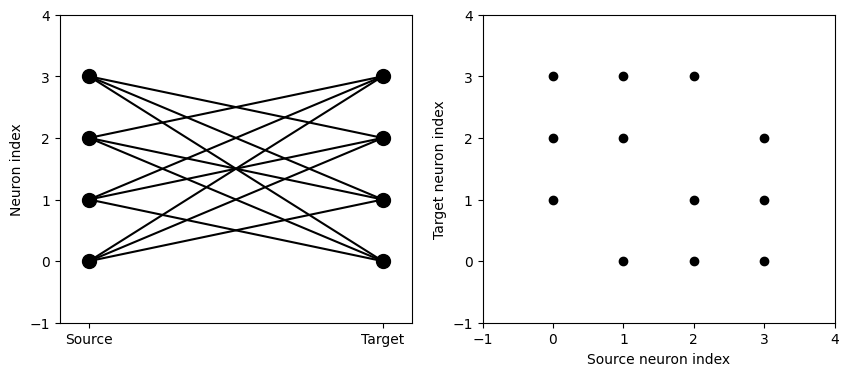

In [9]:
visualise_connectivity(syns_exc_exc_adthr_vstdp)

### Recording + net setup

In [10]:
# Recording 
syns_inp_exc_mon = StateMonitor(syns_inp_exc,  ['w', 'apre', 'apost', 'i', 'j'], record=True)
syns_inp_exc_no_adthr_mon = StateMonitor(syns_inp_exc_no_adthr,  ['w', 'apre', 'apost', 'i', 'j'], record=True)
syns_inp_exc_adthr_sm_noise_mon = StateMonitor(syns_inp_exc_adthr_sm_noise,  ['w', 'apre', 'apost', 'i', 'j'], record=True)
syns_inp_exc_no_adthr_vstdp_mon = StateMonitor(syns_inp_exc_no_adthr_vstdp,  ['w', 'x_trace_prespike', 'i', 'j'], record=True)
syns_inp_exc_adthr_vstdp_mon = StateMonitor(syns_inp_exc_adthr_vstdp,  ['w', 'x_trace_prespike', 'i', 'j'], record=True)

syns_exc_exc_adthr_time_bnoise_mon = StateMonitor(syns_exc_exc_adthr_time_bnoise,  ['w', 'apre', 'apost', 'i', 'j'], record=True)
syns_exc_exc_no_adthr_mon = StateMonitor(syns_exc_exc_no_adthr,  ['w', 'apre', 'apost', 'i', 'j'], record=True)
syns_exc_exc_adthr_time_snoise_mon = StateMonitor(syns_exc_exc_adthr_time_snoise,  ['w', 'apre', 'apost', 'i', 'j'], record=True)
syns_exc_exc_no_adthr_vstdp_mon = StateMonitor(syns_exc_exc_no_adthr_vstdp,  ['w', 'x_trace_prespike', 'i', 'j'], record=True)
syns_exc_exc_adthr_vstdp_mon = StateMonitor(syns_exc_exc_adthr_vstdp,  ['w', 'x_trace_prespike', 'i', 'j'], record=True)


#ng_exc_mon = StateMonitor(ng_exc,  ['v', 'theta', 'ge', 'gi'], record=True)
#ng_exc_no_adthr_mon = StateMonitor(ng_exc_no_adthr,  ['v', 'theta', 'ge', 'gi'], record=True)
#ng_exc_sm_noise_mon = StateMonitor(ng_exc_sm_noise,  ['v', 'theta', 'ge', 'gi'], record=True)
#ng_exc_no_adthr_vstdp_mon = StateMonitor(ng_exc_no_adthr_vstdp,  ['v', 'theta', 'ge', 'gi', 'v_lowpass1', 'v_lowpass2', 'v_homeo'], record=True)
#ng_exc_adthr_vstdp_mon = StateMonitor(ng_exc_adthr_vstdp,  ['v', 'theta', 'ge', 'gi', 'v_lowpass1', 'v_lowpass2', 'v_homeo'], record=True)

ng_exc_spikemon = SpikeMonitor(ng_exc)
ng_exc_no_adthr_spikemon = SpikeMonitor(ng_exc_no_adthr)
ng_exc_sm_noise_spikemon = SpikeMonitor(ng_exc_sm_noise)
ng_exc_no_adthr_vstdp_spikemon = SpikeMonitor(ng_exc_no_adthr_vstdp)
ng_exc_adthr_vstdp_spikemon = SpikeMonitor(ng_exc_adthr_vstdp)

ng_inp_spikemon = SpikeMonitor(pg_inp)

net = Network([pg_inp, ng_exc, ng_exc_no_adthr, ng_exc_sm_noise, ng_exc_no_adthr_vstdp, ng_exc_adthr_vstdp,
               ng_inh, #ng_inh_adthr, ng_inh_no_adthr, #pg_noise,
               syns_inp_exc, syns_exc_inh, syns_inh_exc, syns_exc_exc_adthr_time_bnoise,
               syns_inp_exc_no_adthr, syns_exc_inh_no_adthr, syns_inh_exc_no_adthr, syns_exc_exc_no_adthr,
               syns_inp_exc_adthr_sm_noise, syns_exc_inh_adthr_sm_noise, syns_inh_exc_adthr_sm_noise, syns_exc_exc_adthr_time_snoise,
               syns_inp_exc_no_adthr_vstdp, syns_exc_inh_no_adthr_vstdp, syns_inh_exc_no_adthr_vstdp, syns_exc_exc_no_adthr_vstdp,
               syns_inp_exc_adthr_vstdp, syns_exc_inh_adthr_vstdp, syns_inh_exc_adthr_vstdp, syns_exc_exc_adthr_vstdp,
               syns_inp_exc_mon, syns_exc_exc_adthr_time_bnoise_mon, # ng_exc_mon, 
               syns_inp_exc_no_adthr_mon, syns_exc_exc_no_adthr_mon, # ng_exc_no_adthr_mon,
               syns_inp_exc_adthr_sm_noise_mon, syns_exc_exc_adthr_time_snoise_mon, # ng_exc_sm_noise_mon,
               syns_inp_exc_no_adthr_vstdp_mon, syns_exc_exc_no_adthr_vstdp_mon, # ng_exc_no_adthr_vstdp_mon,
               syns_inp_exc_adthr_vstdp_mon, syns_exc_exc_adthr_vstdp_mon, # ng_exc_adthr_vstdp_mon,
               ng_exc_spikemon, ng_exc_no_adthr_spikemon, ng_exc_sm_noise_spikemon, ng_exc_no_adthr_vstdp_spikemon, ng_exc_adthr_vstdp_spikemon,
               ng_inp_spikemon])

net.run(0*second)

### Run

In [11]:
rest_duration = 100 * ms # 50 * ms # 0 * ms
rest_freq = 0.5 # [Hz]
train_duration = 200 * ms # 100 * ms #  500 * ms



#inp_rates_0 = [6, 2, 2 , 2, 2, 2, 2, 2, 2 , 2,
#                2, 2, 2 , 2, 2, 2, 2, 2, 2 , 2 ] * Hz 

inp_rates_0 = [6, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5 , 0.5,
                0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5 , 0.5 ] * Hz 

#inp_rates_0 = [20, 10, 9 , 8, 7, 6, 5, 4, 3, 2 ,
#                1, 0, 0 , 0, 0, 0, 0, 0, 0 , 0 ] * Hz 


inp_rates_1 = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5 , 0.5,
                0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5 , 6 ] * Hz 

#inp_rates_1 = [2, 2, 2 , 2, 2, 2, 2, 2, 2 , 2,
#                2, 2, 2 , 2, 2, 2, 2, 2, 2 , 6 ] * Hz

#inp_rates_1 = [0, 0, 0 , 0, 0, 0, 0, 0, 0 , 1,
#                 2, 3, 4, 5 , 6, 7, 8, 9, 10 , 20 ] * Hz


inp_rates_2 = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5 , 0.5,
                0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 7, 0.5 , 0.5 ] * Hz 

inp_rates_3 = [0.5, 0.5, 7, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5 , 0.5,
                0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5 , 0.5 ] * Hz 

In [12]:
timing = 0*ms

In [37]:
epoch = 200
for i in range(epoch):
    print(f"step: {i+1}")

    # Train
    net['inp'].rates = inp_rates_0
    net.run(train_duration)
    timing += train_duration

    #rest
    net['inp'].rates = np.ones(N_INP)* rest_freq * Hz
    net.run(rest_duration)
    timing += rest_duration

    # Train
    net['inp'].rates = inp_rates_1
    net.run(train_duration)
    timing += train_duration

    #rest
    net['inp'].rates = np.ones(N_INP) * rest_freq * Hz
    net.run(rest_duration)
    timing += rest_duration

    # Train
    net['inp'].rates = inp_rates_2
    net.run(train_duration)
    timing += train_duration

    #rest
    net['inp'].rates = np.ones(N_INP) * rest_freq * Hz
    net.run(rest_duration)
    timing += rest_duration

    # Train
    net['inp'].rates = inp_rates_3
    net.run(train_duration)
    timing += train_duration

    #rest
    net['inp'].rates = np.ones(N_INP) * rest_freq * Hz
    net.run(rest_duration)
    timing += rest_duration

print("Done")

step: 1
step: 2
step: 3
step: 4
step: 5
step: 6
step: 7
step: 8
step: 9
step: 10
step: 11
step: 12
step: 13
step: 14
step: 15
step: 16
step: 17
step: 18
step: 19
step: 20
step: 21
step: 22
step: 23
step: 24
step: 25
step: 26
step: 27
step: 28
step: 29
step: 30
step: 31
step: 32
step: 33
step: 34
step: 35
step: 36
step: 37
step: 38
step: 39
step: 40
step: 41
step: 42
step: 43
step: 44
step: 45
step: 46
step: 47
step: 48
step: 49
step: 50
step: 51
step: 52
step: 53
step: 54
step: 55
step: 56
step: 57
step: 58
step: 59
step: 60
step: 61
step: 62
step: 63
step: 64
step: 65
step: 66
step: 67
step: 68
step: 69
step: 70
step: 71
step: 72
step: 73
step: 74
step: 75
step: 76
step: 77
step: 78
step: 79
step: 80
step: 81
step: 82
step: 83
step: 84
step: 85
step: 86
step: 87
step: 88
step: 89
step: 90
step: 91
step: 92
step: 93
step: 94
step: 95
step: 96
step: 97
step: 98
step: 99
step: 100
step: 101
step: 102
step: 103
step: 104
step: 105
step: 106
step: 107
step: 108
step: 109
step: 110
step: 11

### Plot

In [42]:
print(timing/ms)

720000.0000000496


In [72]:
print(shape(ng_exc_spikemon.i), shape(ng_exc_no_adthr_spikemon.i))

(150,) (188,)


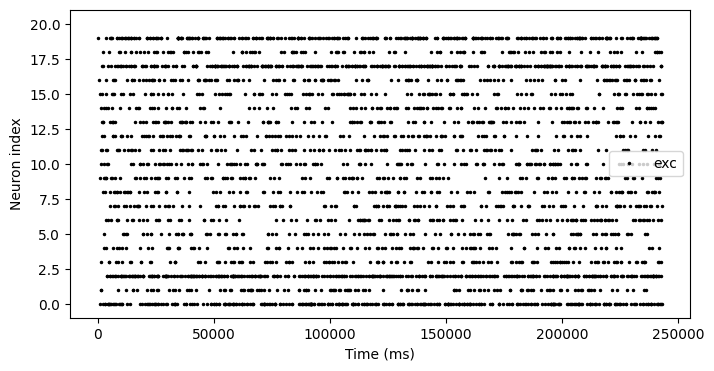

In [25]:
start = 0

plt.figure(figsize=(8, 4)) #sharex=True, sharey=True,
neuron_index_num = N_INP # max(N_NEURONS, N_INP) # N_INP # max(N_NEURONS, N_INP)

plt.plot(ng_inp_spikemon.t[start:]/ms, ng_inp_spikemon.i[start:], '.k', ms=3, label ='exc')
plt.ylim(-1, neuron_index_num+1)
plt.xlabel('Time (ms)')
plt.ylabel('Neuron index')
plt.legend()


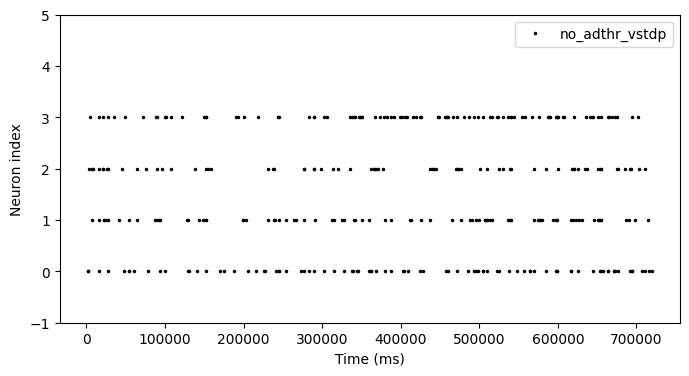

In [39]:
start = 0

plt.figure(figsize=(8, 4)) #sharex=True, sharey=True,
neuron_index_num = N_NEURONS # max(N_NEURONS, N_INP) # N_INP # max(N_NEURONS, N_INP)

plt.plot(ng_exc_no_adthr_vstdp_spikemon.t[start:]/ms, ng_exc_no_adthr_vstdp_spikemon.i[start:], '.k', ms=3, label ='no_adthr_vstdp')
plt.ylim(-1, neuron_index_num+1)
plt.xlabel('Time (ms)')
plt.ylabel('Neuron index')
plt.legend()

Text(0.02, 0.5, 'Neuron index')

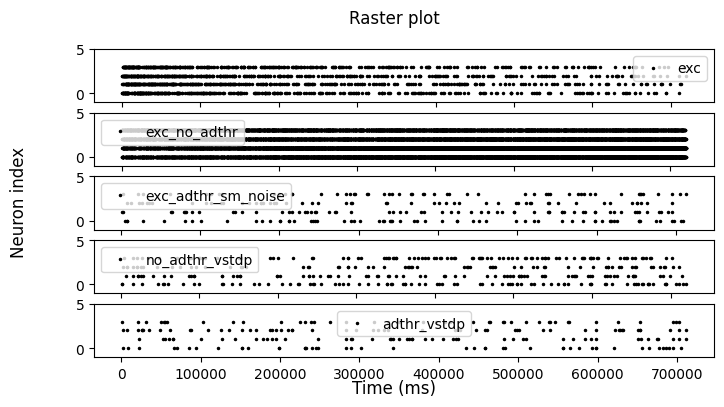

In [40]:
## Referece:
## [1] https://stackoverflow.com/questions/16150819/common-xlabel-ylabel-for-matplotlib-subplots
## [2] https://stackoverflow.com/questions/15858192/how-to-set-xlim-and-ylim-for-a-subplot

start = 0

fig, axs = plt.subplots(5,  figsize=(8, 4)) #sharex=True, sharey=True,
fig.suptitle('Raster plot')
#plot(ng_input_spikemon.t/ms, ng_input_spikemon.i, '.r', ms=3, label = 'inp')
neuron_index_num = N_NEURONS # max(N_NEURONS, N_INP) # N_INP # max(N_NEURONS, N_INP)

axs[0].plot(ng_exc_spikemon.t[start:]/ms, ng_exc_spikemon.i[start:], '.k', ms=3, label ='exc')
axs[0].set_ylim(-1, neuron_index_num+1)
axs[0].legend()

axs[1].plot(ng_exc_no_adthr_spikemon.t[start:]/ms, ng_exc_no_adthr_spikemon.i[start:], '.k', ms=3, label ='exc_no_adthr')
axs[1].set_ylim(-1, neuron_index_num+1)
axs[1].legend()

axs[2].plot(ng_exc_sm_noise_spikemon.t[start:]/ms, ng_exc_sm_noise_spikemon.i[start:], '.k', ms=3, label ='exc_adthr_sm_noise')
axs[2].set_ylim(-1, neuron_index_num+1)
axs[2].legend()

axs[3].plot(ng_exc_no_adthr_vstdp_spikemon.t[start:]/ms, ng_exc_no_adthr_vstdp_spikemon.i[start:], '.k', ms=3, label ='no_adthr_vstdp')
axs[3].set_ylim(-1, neuron_index_num+1)
axs[3].legend()

axs[4].plot(ng_exc_adthr_vstdp_spikemon.t[start:]/ms, ng_exc_adthr_vstdp_spikemon.i[start:], '.k', ms=3, label ='adthr_vstdp')
axs[4].set_ylim(-1, neuron_index_num+1)
axs[4].legend()

fig.supxlabel('Time (ms)')
fig.supylabel('Neuron index')

#legend()

[[1.26395377 1.107786   2.         1.44452707]
 [1.09917912 0.97476717 1.1844376  1.12202286]
 [1.84684771 2.         1.66216924 1.9048299 ]
 [1.1168316  1.10976548 1.1735976  1.19558374]
 [1.05962362 1.14668868 1.19447562 1.22163326]
 [1.03711787 1.2414345  1.13597139 1.08133102]
 [0.9289743  1.03785919 1.13027795 1.20500392]
 [1.09259797 1.13103994 1.34284556 1.00323467]
 [0.94336132 1.34889285 1.19733481 1.19915531]
 [1.04530242 1.11681812 0.80564602 1.13871176]
 [1.07655704 1.19494383 1.40976741 1.09637076]
 [1.30727648 1.17402723 0.95012026 1.26968809]
 [1.28639468 1.36674657 1.23378025 1.12408734]
 [1.28839448 1.2546017  1.07154547 1.18873758]
 [1.02321426 1.00185899 1.1794445  1.09004023]
 [1.13796972 0.93238873 1.34295564 1.13001274]
 [1.05428475 1.18159128 1.01040759 1.09544656]
 [1.39820564 1.61986613 1.58576362 1.52169887]
 [1.154847   1.1236898  1.02668652 0.99544726]
 [1.65296736 1.7619136  1.55757408 1.18219652]]


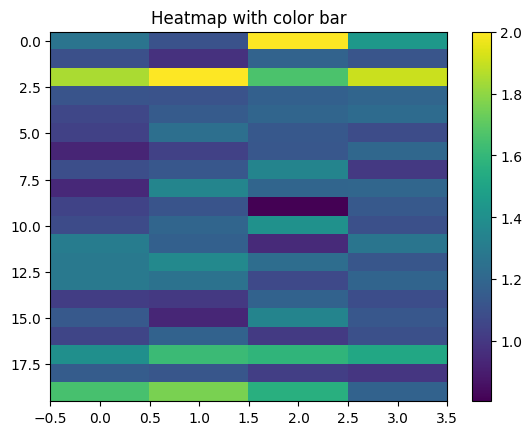

In [41]:
#stored_inp_exc.w = syns_inp_exc_mon.w[:, -1]
W_inp_exc = np.full((len(pg_inp), len(ng_exc)), np.nan)
# Insert the values from the Synapses object
W_inp_exc[syns_inp_exc_mon.i[:,-1], syns_inp_exc_mon.j[:,-1]] = syns_inp_exc_mon.w[:, -1]
#W = syns_inp_exc_mon.w[:, 200000-1]

fig, ax = plt.subplots()
ax.set_title("Heatmap with color bar")
extent = -0.5, N_NEURONS-0.5, -0.5, N_INP-0.5
plt.imshow(W_inp_exc, interpolation='none', origin='upper', aspect='auto')
# Add colorbar 
plt.colorbar() 
print(W_inp_exc)

[[            nan 1.45462448e-001 9.75345376e-002 2.33768929e-002]
 [1.17946033e-002             nan 3.58153856e-143 2.52155952e-010]
 [5.09093199e-002 3.35945177e-001             nan 1.43518772e-002]
 [1.05360885e-001 3.38905208e-001 2.04590248e-001             nan]]


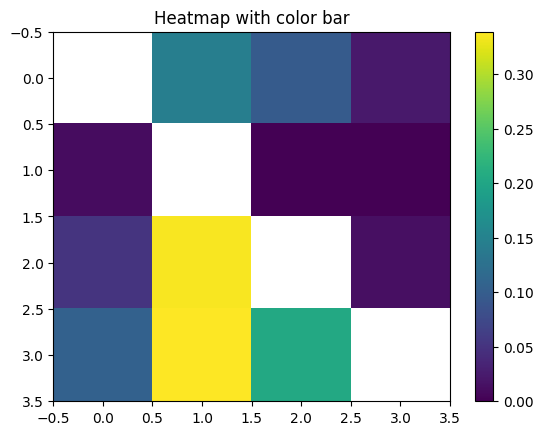

In [45]:
#stored_inp_exc.w = syns_inp_exc_mon.w[:, -1]
W_exc_exc = np.full((len(ng_exc), len(ng_exc)), np.nan)
# Insert the values from the Synapses object
W_exc_exc[syns_exc_exc_adthr_time_bnoise_mon.i[:,-1], syns_exc_exc_adthr_time_bnoise_mon.j[:,-1]] = syns_exc_exc_adthr_time_bnoise_mon.w[:, -1]
#W = syns_inp_exc_mon.w[:, 200000-1]

fig, ax = plt.subplots()
ax.set_title("Heatmap with color bar")
extent = -0.5, N_NEURONS-0.5, -0.5, N_INP-0.5
plt.imshow(W_exc_exc, interpolation='none', origin='upper', aspect='auto')
# Add colorbar 
plt.colorbar() 
print(W_exc_exc)

[[1.9966303  1.99336455 1.98931057 1.98207348]
 [1.99638826 1.97728828 1.98650198 1.99958547]
 [1.96486487 2.         2.         1.9998205 ]
 [1.99244057 2.         2.         1.77887465]
 [2.         2.         1.9947337  1.9999999 ]
 [2.         2.         1.97163454 1.98938879]
 [1.97924355 2.         2.         1.99999994]
 [2.         1.96658988 1.98532065 1.83491747]
 [1.99943278 2.         1.96104973 1.38686919]
 [1.9490522  1.97780274 1.99341907 1.95424991]
 [2.         2.         1.99324462 1.87814235]
 [1.93436576 2.         1.97036136 1.9676653 ]
 [1.95800628 2.         1.99172158 1.99655211]
 [1.99941607 1.99998153 1.99994756 2.        ]
 [1.95940007 2.         2.         1.9950806 ]
 [1.99514693 2.         1.81995166 1.95251033]
 [1.93011273 2.         1.98255286 2.        ]
 [1.98135617 2.         1.91735982 2.        ]
 [1.98567971 2.         1.99930007 1.93273917]
 [1.99007329 2.         2.         1.99999989]]


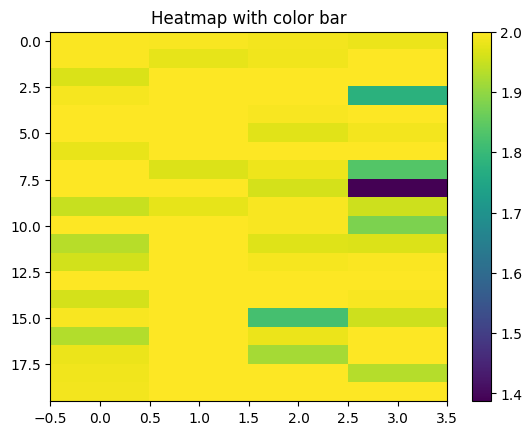

In [46]:
#stored_inp_exc.w = syns_inp_exc_mon.w[:, -1]
W_inp_exc_no_adthr = np.full((len(pg_inp), len(ng_exc_no_adthr)), np.nan)
# Insert the values from the Synapses object
W_inp_exc_no_adthr[syns_inp_exc_no_adthr_mon.i[:,-1:], syns_inp_exc_no_adthr_mon.j[:,-1:]] = syns_inp_exc_no_adthr_mon.w[:, -1:]

fig, ax = plt.subplots()
ax.set_title("Heatmap with color bar")
extent = -0.5, N_NEURONS-0.5, -0.5, N_INP-0.5
plt.imshow(W_inp_exc_no_adthr, interpolation='none', origin='upper', aspect='auto')
# Add colorbar 
plt.colorbar() 
print(W_inp_exc_no_adthr)

[[           nan 2.00000000e+00 2.46561215e-03 1.15071407e-02]
 [0.00000000e+00            nan 0.00000000e+00 0.00000000e+00]
 [1.99357016e+00 1.99760551e+00            nan 7.65067904e-06]
 [1.98716339e+00 2.00000000e+00 1.99978954e+00            nan]]


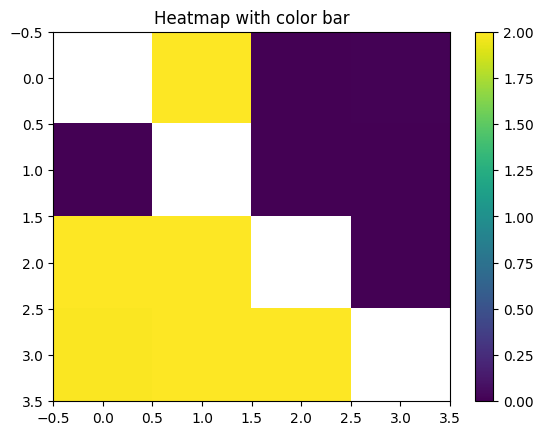

In [47]:
#stored_inp_exc.w = syns_inp_exc_mon.w[:, -1]
W_exc_exc_no_adthr = np.full((len(ng_exc_no_adthr), len(ng_exc_no_adthr)), np.nan)
# Insert the values from the Synapses object
W_exc_exc_no_adthr[syns_exc_exc_no_adthr_mon.i[:,-1:], syns_exc_exc_no_adthr_mon.j[:,-1:]] = syns_exc_exc_no_adthr_mon.w[:, -1:]

fig, ax = plt.subplots()
ax.set_title("Heatmap with color bar")
extent = -0.5, N_NEURONS-0.5, -0.5, N_INP-0.5
plt.imshow(W_exc_exc_no_adthr, interpolation='none', origin='upper', aspect='auto')
# Add colorbar 
plt.colorbar() 
print(W_exc_exc_no_adthr)

[[1.08478811 1.35569896 1.12892216 1.30297195]
 [1.06784796 1.10280185 1.11997654 1.13623831]
 [1.41489292 1.99290642 1.44015931 1.41920743]
 [1.03555936 0.97463875 1.17402758 1.02699685]
 [1.1625941  1.15559276 1.13859469 1.06250426]
 [1.015717   1.13783204 0.97693671 1.08339145]
 [1.14679397 1.15675278 1.07618408 1.15380899]
 [1.07708483 1.0441704  0.94844747 1.14324489]
 [1.14788491 1.10162326 1.08464745 1.03426696]
 [1.07870749 1.124282   1.06025179 1.09460295]
 [1.18941957 1.09943237 0.99189576 1.01969612]
 [1.09956366 1.15744514 1.18290352 1.24760552]
 [1.11450885 1.13830967 1.04147157 1.14746678]
 [1.05093661 1.11467609 1.11842929 1.0859009 ]
 [1.10605194 1.06213811 1.07959055 1.26335053]
 [1.12913908 1.13161624 1.18445866 1.15816046]
 [1.06133603 1.03023463 1.07859479 1.04924414]
 [1.77198448 1.11089009 1.41589928 1.43137784]
 [1.12632763 1.06491074 1.03240214 1.11679761]
 [1.39585733 1.03790838 1.24815521 1.19443019]]


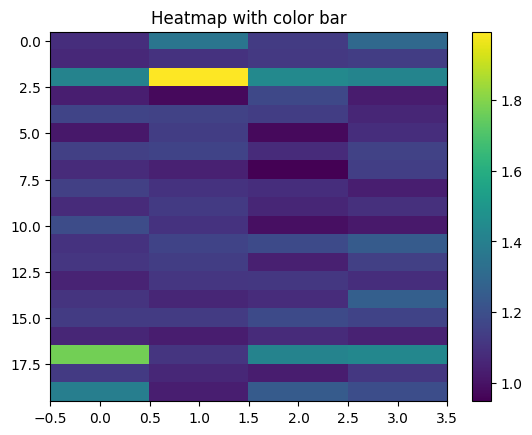

In [48]:
#stored_inp_exc.w = syns_inp_exc_mon.w[:, -1]
W_inp_exc_adthr_sm_nosie = np.full((len(pg_inp), len(ng_exc_sm_noise)), np.nan)
# Insert the values from the Synapses object
W_inp_exc_adthr_sm_nosie[syns_inp_exc_adthr_sm_noise_mon.i[:,-1:], syns_inp_exc_adthr_sm_noise_mon.j[:,-1:]] = syns_inp_exc_adthr_sm_noise_mon.w[:, -1:]

fig, ax = plt.subplots()
ax.set_title("Heatmap with color bar")
extent = -0.5, N_NEURONS-0.5, -0.5, N_INP-0.5
plt.imshow(W_inp_exc_adthr_sm_nosie, interpolation='none', origin='upper', aspect='auto')
# Add colorbar 
plt.colorbar() 
print(W_inp_exc_adthr_sm_nosie)

[[       nan 0.00992065 0.         0.05239647]
 [0.09315238        nan 0.10812754 0.11754374]
 [0.04044084 0.                nan 0.05486475]
 [0.0103231  0.00104151 0.                nan]]


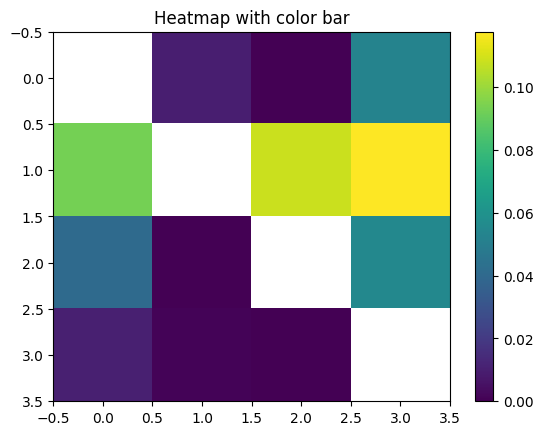

In [49]:
#stored_inp_exc.w = syns_inp_exc_mon.w[:, -1]
W_exc_exc_adthr_sm_nosie = np.full((len(ng_exc_sm_noise), len(ng_exc_sm_noise)), np.nan)
# Insert the values from the Synapses object
W_exc_exc_adthr_sm_nosie[syns_exc_exc_adthr_time_snoise_mon.i[:,-1:], syns_exc_exc_adthr_time_snoise_mon.j[:,-1:]] = syns_exc_exc_adthr_time_snoise_mon.w[:, -1:]

fig, ax = plt.subplots()
ax.set_title("Heatmap with color bar")
extent = -0.5, N_NEURONS-0.5, -0.5, N_INP-0.5
plt.imshow(W_exc_exc_adthr_sm_nosie, interpolation='none', origin='upper', aspect='auto')
# Add colorbar 
plt.colorbar() 
print(W_exc_exc_adthr_sm_nosie)

[[0.9732479  0.98014907 0.97577676 0.97084867]
 [0.98987837 0.99576627 0.98865904 1.0090017 ]
 [1.05445515 1.00198306 0.97687739 1.00297245]
 [1.00306668 0.99651056 0.99045652 1.01731432]
 [1.02252883 1.01904382 1.01639383 1.02908736]
 [1.02074158 1.00142014 1.01776991 1.00494494]
 [1.03702903 1.00971364 0.99999593 1.03715472]
 [1.03698203 1.01645505 1.03075642 1.03630398]
 [1.02112617 0.99815864 1.04697398 1.01528491]
 [1.01960813 1.06136599 1.02062968 1.01445367]
 [1.04025977 1.05897161 1.016727   1.12168258]
 [1.07953944 1.06753211 1.08012551 1.08603597]
 [1.06187106 1.04242943 1.04176708 1.05777796]
 [1.0288919  1.02913823 1.0295648  1.02526381]
 [1.08042109 1.01674823 1.03709975 1.07362085]
 [1.06109816 1.04980233 1.03920752 1.16065737]
 [1.10088003 1.01110452 1.09945924 0.99450942]
 [1.30838535 1.06911011 1.26359862 1.30560025]
 [1.01757239 1.07855034 1.04308264 1.11471664]
 [1.34299809 1.28186733 1.1775882  1.39620484]]


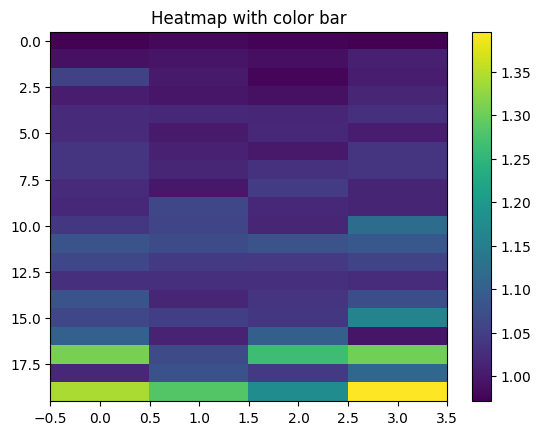

In [50]:
#stored_inp_exc.w = syns_inp_exc_mon.w[:, -1]
W_inp_exc_no_adthr_vstdp = np.full((len(pg_inp), len(ng_exc_no_adthr_vstdp)), np.nan)
# Insert the values from the Synapses object
W_inp_exc_no_adthr_vstdp[syns_inp_exc_no_adthr_vstdp_mon.i[:,-1:], syns_inp_exc_no_adthr_vstdp_mon.j[:,-1:]] = syns_inp_exc_no_adthr_vstdp_mon.w[:, -1:]

fig, ax = plt.subplots()
ax.set_title("Heatmap with color bar")
extent = -0.5, N_NEURONS-0.5, -0.5, N_INP-0.5
plt.imshow(W_inp_exc_no_adthr_vstdp, interpolation='none', origin='upper', aspect='auto')
# Add colorbar 
plt.colorbar() 
print(W_inp_exc_no_adthr_vstdp)

[[       nan 0.10080646 0.02114667 0.1714909 ]
 [0.0180131         nan 0.05398347 0.07933381]
 [0.03031435 0.06608034        nan 0.03359125]
 [0.04623117 0.09130065 0.08470894        nan]]


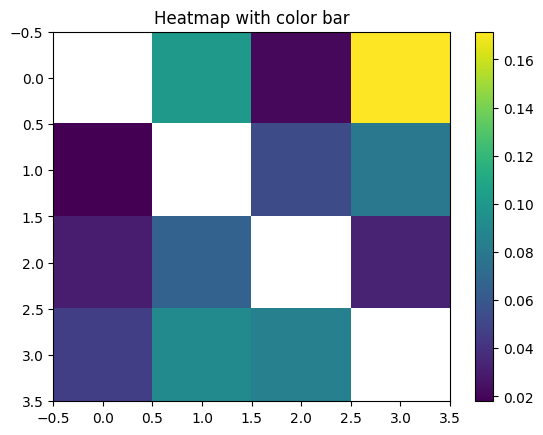

In [51]:
#stored_inp_exc.w = syns_inp_exc_mon.w[:, -1]
W_exc_exc_no_adthr_vstdp = np.full((len(ng_exc_no_adthr_vstdp), len(ng_exc_no_adthr_vstdp)), np.nan)
# Insert the values from the Synapses object
W_exc_exc_no_adthr_vstdp[syns_exc_exc_no_adthr_vstdp_mon.i[:,-1:], syns_exc_exc_no_adthr_vstdp_mon.j[:,-1:]] = syns_exc_exc_no_adthr_vstdp_mon.w[:, -1:]

fig, ax = plt.subplots()
ax.set_title("Heatmap with color bar")
extent = -0.5, N_NEURONS-0.5, -0.5, N_INP-0.5
plt.imshow(W_exc_exc_no_adthr_vstdp, interpolation='none', origin='upper', aspect='auto')
# Add colorbar 
plt.colorbar() 
print(W_exc_exc_no_adthr_vstdp)

[[0.97385644 0.97579032 0.98222845 0.99027013]
 [0.9939589  0.99790895 0.99144708 1.00120683]
 [1.01044097 1.00073699 1.01459105 0.99261665]
 [0.99590337 0.99075642 0.99412841 0.99224271]
 [0.99551866 1.00746232 1.01047578 1.01150946]
 [0.99883202 0.99620518 1.00461457 1.0174971 ]
 [1.00258301 1.00807223 1.02326925 1.01326682]
 [1.02450498 1.0016357  1.00200134 1.00842613]
 [1.00350068 1.01012736 1.02090395 1.00580474]
 [1.00803635 1.00743716 1.01183493 1.01938609]
 [1.03100891 1.00975466 1.03990954 0.99230924]
 [1.05270901 1.0299906  1.0418705  1.04827329]
 [1.02323127 1.01307405 1.02368001 1.04631453]
 [1.01822207 1.04863139 1.0286923  1.00357025]
 [1.05538287 1.02923234 1.02693911 1.07103733]
 [1.0303665  1.08377819 1.04326763 1.0370484 ]
 [1.02801464 1.05859825 1.03144837 1.0020957 ]
 [1.07974101 1.31467699 1.16827945 1.04622005]
 [1.07796233 1.0299153  1.02309384 0.99112289]
 [1.12502604 1.04780733 1.15683341 1.07408845]]


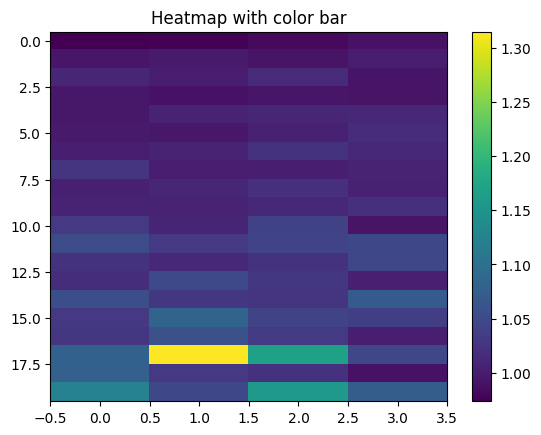

In [52]:
#stored_inp_exc.w = syns_inp_exc_mon.w[:, -1]
W_inp_exc_adthr_vstdp = np.full((len(pg_inp), len(ng_exc_adthr_vstdp)), np.nan)
# Insert the values from the Synapses object
W_inp_exc_adthr_vstdp[syns_inp_exc_adthr_vstdp_mon.i[:,-1:], syns_inp_exc_adthr_vstdp_mon.j[:,-1:]] = syns_inp_exc_adthr_vstdp_mon.w[:, -1:]

fig, ax = plt.subplots()
ax.set_title("Heatmap with color bar")
extent = -0.5, N_NEURONS-0.5, -0.5, N_INP-0.5
plt.imshow(W_inp_exc_adthr_vstdp, interpolation='none', origin='upper', aspect='auto')
# Add colorbar 
plt.colorbar() 
print(W_inp_exc_adthr_vstdp)

[[       nan 0.05973242 0.08241872 0.04618166]
 [0.00714869        nan 0.04342784 0.08121708]
 [0.05327081 0.0761829         nan 0.05702383]
 [0.02705332 0.05456314 0.04646927        nan]]


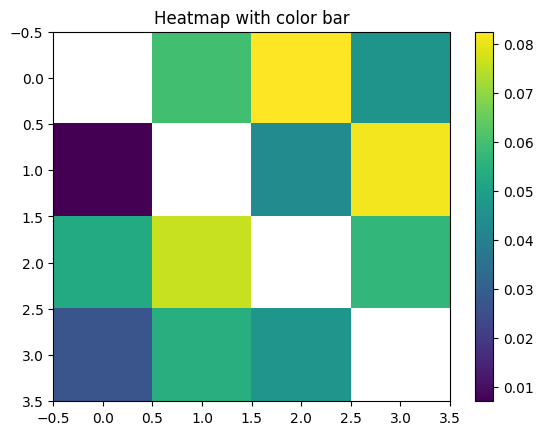

In [53]:
#stored_inp_exc.w = syns_inp_exc_mon.w[:, -1]
W_exc_exc_adthr_vstdp = np.full((len(ng_exc_adthr_vstdp), len(ng_exc_adthr_vstdp)), np.nan)
# Insert the values from the Synapses object
W_exc_exc_adthr_vstdp[syns_exc_exc_adthr_vstdp_mon.i[:,-1:], syns_exc_exc_adthr_vstdp_mon.j[:,-1:]] = syns_exc_exc_adthr_vstdp_mon.w[:, -1:]

fig, ax = plt.subplots()
ax.set_title("Heatmap with color bar")
extent = -0.5, N_NEURONS-0.5, -0.5, N_INP-0.5
plt.imshow(W_exc_exc_adthr_vstdp, interpolation='none', origin='upper', aspect='auto')
# Add colorbar 
plt.colorbar()
print(W_exc_exc_adthr_vstdp)

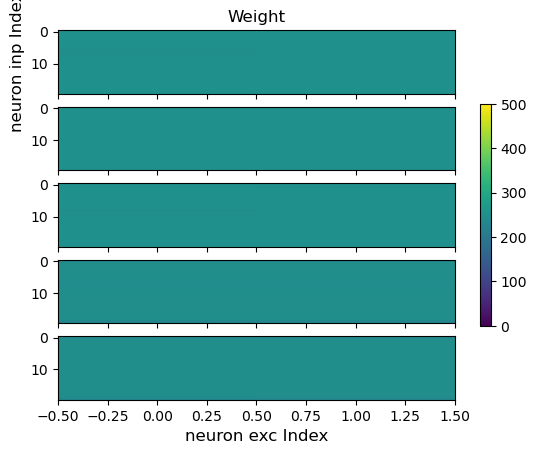

In [291]:
## Reference:
# [1] https://matplotlib.org/stable/gallery/subplots_axes_and_figures/subfigures.html

#stored_inp_exc.w = syns_inp_exc_mon.w[:, -1]
#W_inp_exc = np.full((len(pg_inp), len(ng_exc)), np.nan)
# Insert the values from the Synapses object
#W_inp_exc[syns_inp_exc_mon.i[:,-1:], syns_inp_exc_mon.j[:,-1:]] = syns_inp_exc_mon.w[:, -1:]

#stored_inp_exc.w = syns_inp_exc_mon.w[:, -1]
#W_inp_exc_no_adthr = np.full((len(pg_inp), len(ng_exc_no_adthr)), np.nan)
# Insert the values from the Synapses object
#W_inp_exc_no_adthr[syns_inp_exc_no_adthr_mon.i[:,-1:], syns_inp_exc_no_adthr_mon.j[:,-1:]] = syns_inp_exc_no_adthr_mon.w[:, -1:]

#stored_inp_exc.w = syns_inp_exc_mon.w[:, -1]
#W_inp_exc_adthr_sm_nosie = np.full((len(pg_inp), len(ng_exc_sm_noise)), np.nan)
# Insert the values from the Synapses object
#W_inp_exc_adthr_sm_nosie[syns_inp_exc_adthr_sm_noise_mon.i[:,-1:], syns_inp_exc_adthr_sm_noise_mon.j[:,-1:]] = syns_inp_exc_adthr_sm_noise_mon.w[:, -1:]

# must set vmin, vmax, so that the colobar is shared correctly
vmin = 0
vmax = wmax
fontsize=12
fig, axsRight = subplots(5, sharex=True)
pc = axsRight[0].imshow(W_inp_exc, interpolation='none', origin='upper', aspect='auto', vmin=vmin, vmax=vmax)
#axsRight[0].set_xlabel('neuron exc Index', fontsize=fontsize)
axsRight[0].set_ylabel('neuron inp Index', fontsize=fontsize)
axsRight[0].set_title('Weight', fontsize=fontsize)

pc = axsRight[1].imshow(W_inp_exc_no_adthr, interpolation='none', origin='upper', aspect='auto', vmin=vmin, vmax=vmax)
#axsRight[1].set_xlabel('neuron exc Index', fontsize=fontsize)
#axsRight[1].set_ylabel('neuron inp Index', fontsize=fontsize)
#axsRight[1].set_title('Title', fontsize=fontsize)

pc = axsRight[2].imshow(W_inp_exc_adthr_sm_nosie, interpolation='none', origin='upper', aspect='auto', vmin=vmin, vmax=vmax)
#axsRight[2].set_xlabel('neuron exc Index', fontsize=fontsize)


pc = axsRight[3].imshow(W_inp_exc_no_adthr_vstdp, interpolation='none', origin='upper', aspect='auto', vmin=vmin, vmax=vmax)
#axsRight[3].set_xlabel('neuron exc Index', fontsize=fontsize)

pc = axsRight[4].imshow(W_inp_exc_adthr_vstdp, interpolation='none', origin='upper', aspect='auto', vmin=vmin, vmax=vmax)
axsRight[4].set_xlabel('neuron exc Index', fontsize=fontsize)


colorbar(pc, shrink=0.6, ax=axsRight)
#suptitle('Weights', fontsize='x-large')
show()

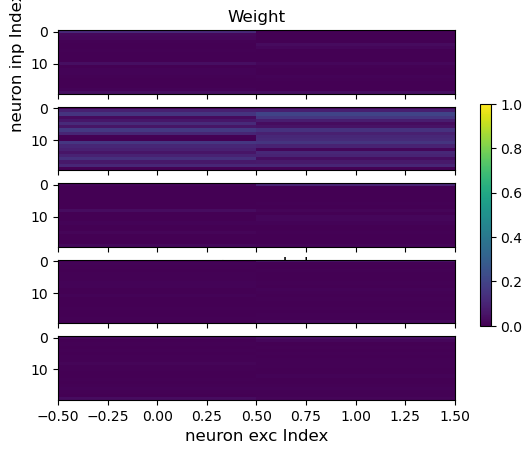

In [620]:
Diff_inp_exc = abs(W_inp_exc - prev_inp_exc)
Diff_inp_exc_no_adthr = abs(W_inp_exc_no_adthr - prev_inp_excc_no_adthr)
Diff_inp_exc_sm_nosie = abs(W_inp_exc_adthr_sm_nosie - prev_inp_exc_adthr_sm_nosie)
Diff_inp_exc_no_adthr_vstdp = abs(W_inp_exc_no_adthr_vstdp - prev_inp_exc_no_adthr_vstdp)
Diff_inp_exc_adthr_vstdp = abs(W_inp_exc_adthr_vstdp - prev_inp_exc_adthr_vstdp)

# must set vmin, vmax, so that the colobar is shared correctly
vmin =  0
vmax = 1
fontsize=12
fig, axsRight = subplots(5, sharex=True)
pc = axsRight[0].imshow(Diff_inp_exc, interpolation='none', origin='upper', aspect='auto', vmin=vmin, vmax=vmax)
#axsRight[0].set_xlabel('neuron exc Index', fontsize=fontsize)
axsRight[0].set_ylabel('neuron inp Index', fontsize=fontsize)
axsRight[0].set_title('Weight', fontsize=fontsize)

pc = axsRight[1].imshow(Diff_inp_exc_no_adthr, interpolation='none', origin='upper', aspect='auto', vmin=vmin, vmax=vmax)
#axsRight[1].set_xlabel('neuron exc Index', fontsize=fontsize)
#axsRight[1].set_ylabel('neuron inp Index', fontsize=fontsize)
#axsRight[1].set_title('Title', fontsize=fontsize)

pc = axsRight[2].imshow(Diff_inp_exc_sm_nosie, interpolation='none', origin='upper', aspect='auto', vmin=vmin, vmax=vmax)
axsRight[2].set_xlabel('neuron exc Index', fontsize=fontsize)
#axsRight[2].set_ylabel('neuron inp Index', fontsize=fontsize)
#axsRight[1].set_title('Title', fontsize=fontsize)

pc = axsRight[3].imshow(Diff_inp_exc_no_adthr_vstdp, interpolation='none', origin='upper', aspect='auto', vmin=vmin, vmax=vmax)


pc = axsRight[4].imshow(Diff_inp_exc_adthr_vstdp, interpolation='none', origin='upper', aspect='auto', vmin=vmin, vmax=vmax)
axsRight[4].set_xlabel('neuron exc Index', fontsize=fontsize)


colorbar(pc, shrink=0.6, ax=axsRight)
#suptitle('Weights', fontsize='x-large')
show()


In [621]:
prev_inp_exc = W_inp_exc
prev_inp_excc_no_adthr = W_inp_exc_no_adthr
prev_inp_exc_adthr_sm_nosie = W_inp_exc_adthr_sm_nosie
prev_inp_exc_no_adthr_vstdp = W_inp_exc_no_adthr_vstdp
prev_inp_exc_adthr_vstdp = W_inp_exc_adthr_vstdp

In [622]:
# average of total weight of all the synapses
avr_sum_w = []
avr_sum_w_no_adthr = []
avr_sum_w_adthr_sm_nosie = []
avr_sum_w_no_adthr_vstdp = []
avr_sum_w_adthr_vstdp = []

# average the weight over every 100ms, over number of total synapses
time_interval = 1e4 *ms
num_w = int(time_interval / defaultclock.dt)

#window = np.arange(100000 * ms, 200000 * ms, defaultclock.dt) / ms
time_window = 6.5e5* ms
for i in range(int(time_window/time_interval)): # range(2): # range(int(1/1e-3)):
#for i in window: # range(2): # range(int(1/1e-3)):
    avr_over_time = np.average(syns_inp_exc_mon.w[:, int(i*num_w):int((i+1)*num_w -1)], axis=1,  keepdims=True)
    avr_over_time_no_adthr = np.average(syns_inp_exc_no_adthr_mon.w[:, int(i*num_w):int((i+1)*num_w -1)], axis=1,  keepdims=True)
    avr_over_time_adthr_sm_nosie = np.average(syns_inp_exc_adthr_sm_noise_mon.w[:, int(i*num_w):int((i+1)*num_w -1)], axis=1,  keepdims=True)
    avr_over_time_no_adthr_vstdp = np.average(syns_inp_exc_no_adthr_vstdp_mon.w[:, int(i*num_w):int((i+1)*num_w -1)], axis=1,  keepdims=True)
    avr_over_time_adthr_vstdp = np.average(syns_inp_exc_adthr_vstdp_mon.w[:, int(i*num_w):int((i+1)*num_w -1)], axis=1,  keepdims=True)
    #print(shape(avr_over_time))
    avr_over_synap = np.average(avr_over_time, axis=0,  keepdims=True)
    avr_over_synap_no_adthr = np.average(avr_over_time_no_adthr, axis=0,  keepdims=True)
    avr_over_synap_adthr_sm_nosie = np.average(avr_over_time_adthr_sm_nosie, axis=0,  keepdims=True)
    avr_over_synap_no_adthr_vstdp = np.average(avr_over_time_no_adthr_vstdp, axis=0,  keepdims=True)
    avr_over_synap_adthr_vstdp = np.average(avr_over_time_adthr_vstdp, axis=0,  keepdims=True)
    #print(shape(avr_over_synap))
    # flattened
    avr_over_synap = np.reshape(avr_over_synap, (-1))
    avr_over_synap_no_adthr = np.reshape(avr_over_synap_no_adthr, (-1))
    avr_over_synap_adthr_sm_nosie = np.reshape(avr_over_synap_adthr_sm_nosie, (-1))
    avr_over_synap_no_adthr_vstdp = np.reshape(avr_over_synap_no_adthr_vstdp, (-1))
    avr_over_synap_adthr_vstdp = np.reshape(avr_over_synap_adthr_vstdp, (-1))
    #print(shape(avr_over_synap))
    avr_sum_w.append(avr_over_synap)
    avr_sum_w_no_adthr.append(avr_over_synap_no_adthr)
    avr_sum_w_adthr_sm_nosie.append(avr_over_synap_adthr_sm_nosie)
    avr_sum_w_no_adthr_vstdp.append(avr_over_synap_no_adthr_vstdp)
    avr_sum_w_adthr_vstdp.append(avr_over_synap_adthr_vstdp)


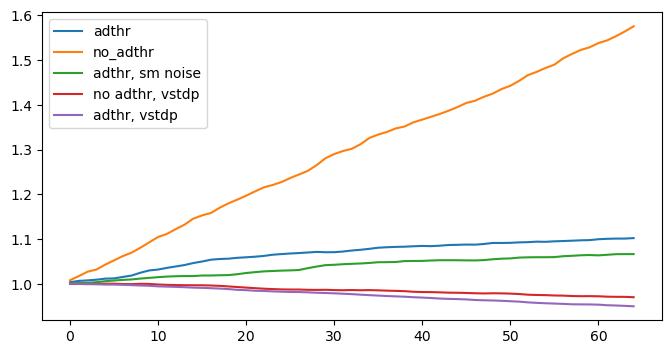

In [623]:
figure(figsize=(8, 4))
plot(np.arange(len(avr_sum_w)), avr_sum_w, label = 'adthr')
plot(np.arange(len(avr_sum_w_no_adthr)), avr_sum_w_no_adthr, label = 'no_adthr')
plot(np.arange(len(avr_sum_w_adthr_sm_nosie)), avr_sum_w_adthr_sm_nosie, label = 'adthr, sm noise')
plot(np.arange(len(avr_sum_w_no_adthr_vstdp)), avr_sum_w_no_adthr_vstdp, label = 'no adthr, vstdp')
plot(np.arange(len(avr_sum_w_adthr_vstdp)), avr_sum_w_adthr_vstdp, label = 'adthr, vstdp')
legend()
show()

## Test

#### Run only once when starting test phase

In [ ]:
t_timing = timing

In [ ]:
test_start_marks = [t_timing]

#### Run again multiple time, after each test phase 

In [141]:
len_dep_stdp_adptr_timer = len(ng_exc_spikemon.t)
len_dep_stdp_no_adptr = len(ng_exc_no_adthr_spikemon.t)
len_dep_stdp_adptr_timer_smn = len(ng_exc_sm_noise_spikemon.t)
len_volt_stdp_no_adptr = len(ng_exc_no_adthr_vstdp_spikemon.t)
len_volt_stdp_adptr = len(ng_exc_adthr_vstdp_spikemon.t)
print(f"len of dep stdp, adptr, timer: {len_dep_stdp_adptr_timer}")
print(f"len of dep stdp, no adptr: {len_dep_stdp_no_adptr}")
print(f"len of dep stdp, adptr, timer, smn: {len_dep_stdp_adptr_timer_smn}")
print(f"len of volt stdp, no adptr: {len_volt_stdp_no_adptr}")
print(f"len of volt stdp, adptr: {len_volt_stdp_adptr}")

len of dep stdp, adptr, timer: 1661
len of dep stdp, no adptr: 27389
len of dep stdp, adptr, timer, smn: 277
len of volt stdp, no adptr: 400
len of volt stdp, adptr: 212


### test plot

#### dep stdp, adptr, timer

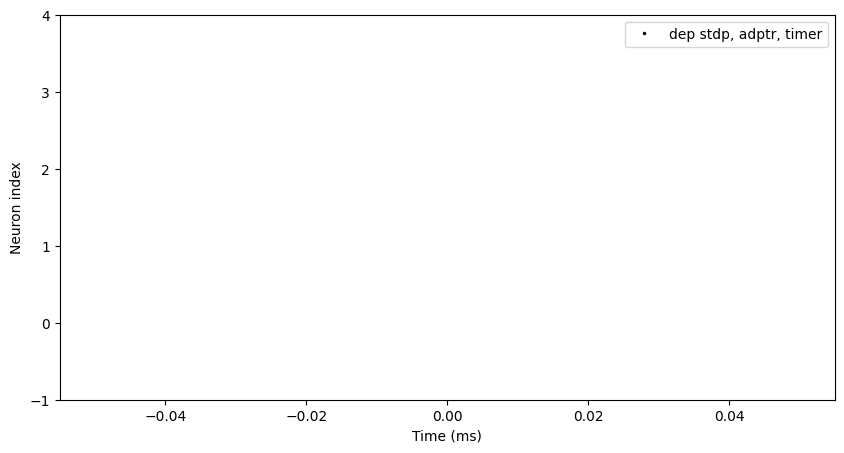

In [142]:
start = len_dep_stdp_adptr_timer
plt.figure(figsize=(10, 5)) 
neuron_index_num = N_NEURONS 
plt.plot(ng_exc_spikemon.t[start:]/ms, ng_exc_spikemon.i[start:], '.k', ms=3, label ='dep stdp, adptr, timer')
plt.axhline(y = 10, color = 'r', linestyle = '-') 
for i, elem in enumerate(test_start_marks):
    plt.axvline(x = elem/ms, color = 'b', linestyle = '--')
plt.ylim(-1, neuron_index_num)
plt.xlabel('Time (ms)')
plt.ylabel('Neuron index')
plt.legend()

#### dep stdp, no adptr

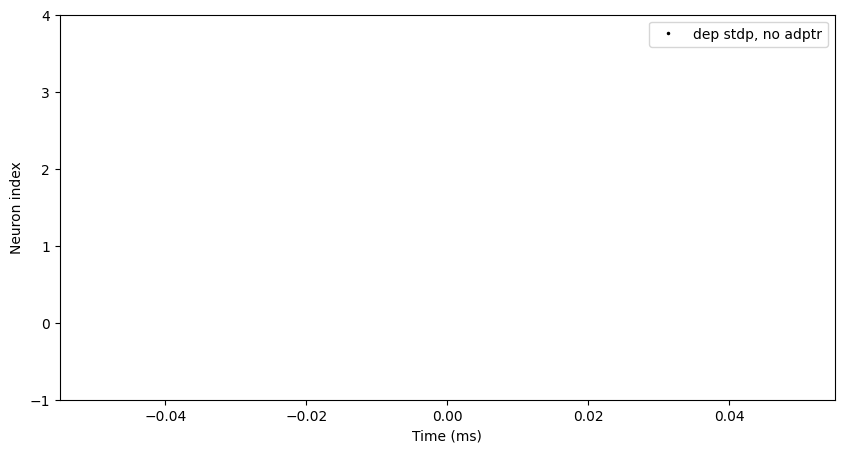

In [143]:
start = len_dep_stdp_no_adptr
plt.figure(figsize=(10, 5)) 
neuron_index_num = N_NEURONS 
plt.plot(ng_exc_no_adthr_spikemon.t[start:]/ms, ng_exc_no_adthr_spikemon.i[start:], '.k', ms=3, label ='dep stdp, no adptr')
for i, elem in enumerate(test_start_marks):
    plt.axvline(x = elem/ms, color = 'b', linestyle = '--')
plt.ylim(-1, neuron_index_num)
plt.xlabel('Time (ms)')
plt.ylabel('Neuron index')
plt.legend()

#### dep stdp, adptr, timer, smn

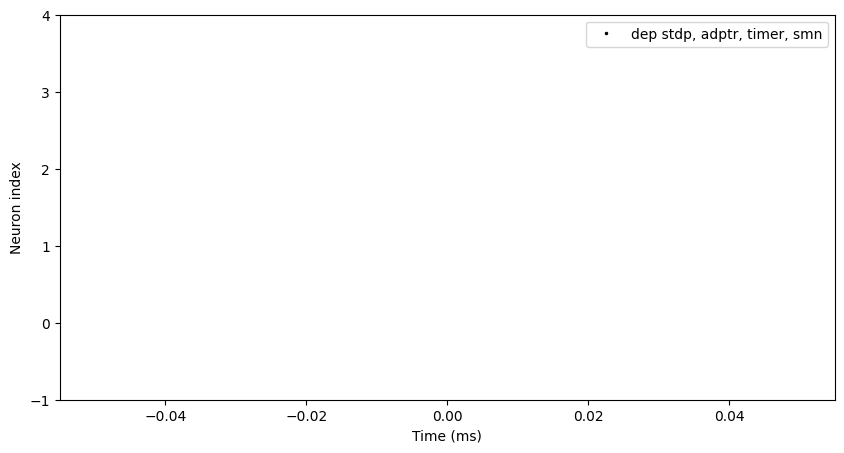

In [144]:
start = len_dep_stdp_adptr_timer_smn
plt.figure(figsize=(10, 5)) 
neuron_index_num = N_NEURONS 
plt.plot(ng_exc_sm_noise_spikemon.t[start:]/ms, ng_exc_sm_noise_spikemon.i[start:], '.k', ms=3, label ='dep stdp, adptr, timer, smn')
for i, elem in enumerate(test_start_marks):
    plt.axvline(x = elem/ms, color = 'b', linestyle = '--')
plt.ylim(-1, neuron_index_num)
plt.xlabel('Time (ms)')
plt.ylabel('Neuron index')
plt.legend()

#### volt stdp, no adptr

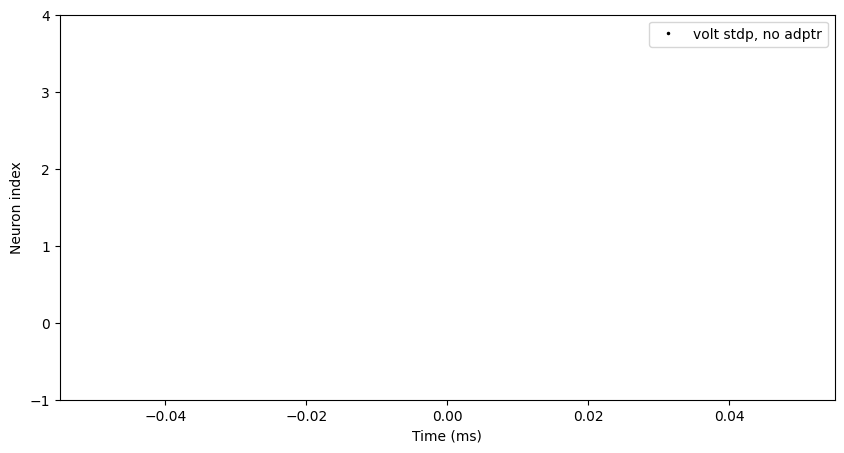

In [145]:
start = len_volt_stdp_no_adptr
plt.figure(figsize=(10, 5)) 
neuron_index_num = N_NEURONS 
plt.plot(ng_exc_no_adthr_vstdp_spikemon.t[start:]/ms, ng_exc_no_adthr_vstdp_spikemon.i[start:], '.k', ms=3, label ='volt stdp, no adptr')
for i, elem in enumerate(test_start_marks):
    plt.axvline(x = elem/ms, color = 'b', linestyle = '--')
plt.ylim(-1, neuron_index_num)
plt.xlabel('Time (ms)')
plt.ylabel('Neuron index')
plt.legend()

#### volt stdp, adptr

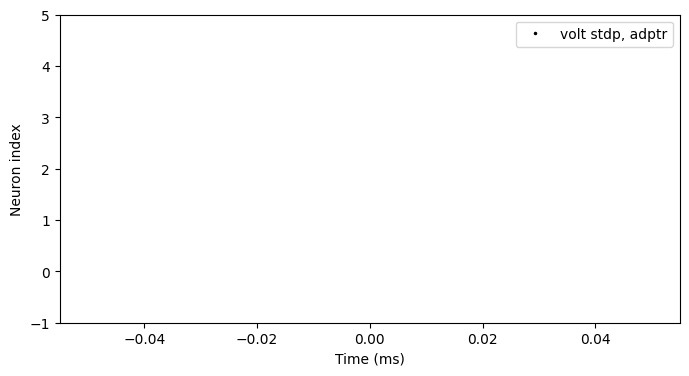

In [146]:
start = len_volt_stdp_adptr
plt.figure(figsize=(8, 4)) 
neuron_index_num = N_NEURONS 
plt.plot(ng_exc_adthr_vstdp_spikemon.t[start:]/ms, ng_exc_adthr_vstdp_spikemon.i[start:], '.k', ms=3, label ='volt stdp, adptr')
for i, elem in enumerate(test_start_marks):
    plt.axvline(x = elem/ms, color = 'b', linestyle = '--')
plt.ylim(-1, neuron_index_num+1)
plt.xlabel('Time (ms)')
plt.ylabel('Neuron index')
plt.legend()

### test run

In [147]:
print(t_timing/ms)

948000.0000000513


In [148]:
test_start_marks = []

In [149]:
train_time_fac = 5
rest_time_fac = 10

In [ ]:
epoch = 10
for i in range(epoch):
    print(f"step: {i+1}")

    # Train
    test_start_marks.append(t_timing)
    net['inp'].rates = inp_rates_0
    net.run(train_time_fac*train_duration)
    t_timing += train_time_fac*train_duration

    #rest
    net['inp'].rates = np.ones(N_INP)* rest_freq * Hz
    net.run(rest_time_fac*rest_duration)
    t_timing += rest_time_fac*rest_duration

    # Train
    test_start_marks.append(t_timing)
    net['inp'].rates = inp_rates_1
    net.run(train_time_fac*train_duration)
    t_timing += train_time_fac*train_duration

    #rest
    net['inp'].rates = np.ones(N_INP) * rest_freq * Hz
    net.run(rest_time_fac*rest_duration)
    t_timing += rest_time_fac*rest_duration

    # Train
    test_start_marks.append(t_timing)
    net['inp'].rates = inp_rates_2
    net.run(train_time_fac*train_duration)
    t_timing += train_time_fac*train_duration

    #rest
    net['inp'].rates = np.ones(N_INP) * rest_freq * Hz
    net.run(rest_time_fac*rest_duration)
    t_timing += rest_time_fac*rest_duration

    # Train
    test_start_marks.append(t_timing)
    net['inp'].rates = inp_rates_3
    net.run(train_time_fac*train_duration)
    t_timing += train_time_fac*train_duration

    #rest
    net['inp'].rates = np.ones(N_INP) * rest_freq * Hz
    net.run(rest_time_fac*rest_duration)
    t_timing += rest_time_fac*rest_duration

    #rest after each evaluation
    test_start_marks.append(t_timing)
    net['inp'].rates = np.ones(N_INP)* rest_freq * Hz
    net.run(50*rest_duration)
    t_timing += 50*rest_duration

print("Done")

step: 1
step: 2
step: 3
step: 4
step: 5
step: 6
step: 7
step: 8


## Save and Load

### Save

In [637]:
def save_npy(arr, path):
    arr = np.array(arr)
    print('%-9s %-15s => %-30s' % ('Saving', arr.shape, path))
    np.save(path, arr)

In [638]:
from pathlib import Path

In [639]:
Path.cwd()

WindowsPath('C:/Users/20245580/JupyterNotebookFiles')

In [640]:
DATA_PATH = Path('data/Exp2_DepStdp_AdapThres_2outputs/VStdp_include')

In [980]:
print(shape(syns_inp_exc_mon.w))

(40, 3240000)


In [981]:
all_w_over_trials_saved = syns_inp_exc_mon.w
print(shape(all_w_over_trials_saved))

(40, 3240000)


In [982]:
print(shape(net['exc'].theta), net['exc'].theta)

(2,) <exc.theta: array([0.01583984, 0.01605909])>


In [641]:
#athr, 
save_npy(net['inp_exc'].apre, DATA_PATH / 'apre_adthr.npy')
save_npy(net['inp_exc'].apost, DATA_PATH / 'apost_adthr.npy')
save_npy(syns_inp_exc_mon.w, DATA_PATH / 'all_w_adthr.npy')
save_npy(net['exc'].theta, DATA_PATH / 'theta_adthr.npy')
save_npy(net['exc'].ge, DATA_PATH / 'ge_adthr.npy')
save_npy(net['exc'].gi, DATA_PATH / 'gi_adthr.npy')
save_npy(net['exc'].v, DATA_PATH / 'v_adthr.npy')

#no adthr
save_npy(net['inp_exc_no_adthr'].apre, DATA_PATH / 'apre_no_adthr.npy')
save_npy(net['inp_exc_no_adthr'].apost, DATA_PATH / 'apost_no_adthr.npy')
save_npy(syns_inp_exc_no_adthr_mon.w, DATA_PATH / 'all_w_no_adthr.npy')
save_npy(net['exc_no_adthr'].theta, DATA_PATH / 'theta_no_adthr.npy')
save_npy(net['exc_no_adthr'].ge, DATA_PATH / 'ge_no_adthr.npy')
save_npy(net['exc_no_adthr'].gi, DATA_PATH / 'gi_no_adthr.npy')
save_npy(net['exc_no_adthr'].v, DATA_PATH / 'v_no_adthr.npy')

# adthr, small noise
save_npy(net['inp_exc_no_adthr_sm_nosie'].apre, DATA_PATH / 'apre_no_adthr_sm_nosie.npy')
save_npy(net['inp_exc_no_adthr_sm_nosie'].apost, DATA_PATH / 'apost_no_adthr_sm_nosie.npy')
save_npy(syns_inp_exc_adthr_sm_noise_mon.w, DATA_PATH / 'all_w_no_adthr_sm_nosie.npy')
save_npy(net['exc_sm_noise'].theta, DATA_PATH / 'theta_no_adthr_sm_nosie.npy')
save_npy(net['exc_sm_noise'].ge, DATA_PATH / 'ge_no_adthr_sm_nosie.npy')
save_npy(net['exc_sm_noise'].gi, DATA_PATH / 'gi_no_adthr_sm_nosie.npy')
save_npy(net['exc_sm_noise'].v, DATA_PATH / 'v_no_adthr_sm_nosie.npy')


# no adthr, vstdp
save_npy(net['inp_exc_no_adthr_vstdp'].x_trace_prespike, DATA_PATH / 'x_trace_no_adthr_vstdp.npy')
save_npy(syns_inp_exc_no_adthr_vstdp.w, DATA_PATH / 'all_w_no_adthr_vstdp.npy')
save_npy(net['exc_no_adthr_vstdp'].theta, DATA_PATH / 'theta_no_adthr_vstdp.npy')
save_npy(net['exc_no_adthr_vstdp'].ge, DATA_PATH / 'ge_no_adthr_vstdp.npy')
save_npy(net['exc_no_adthr_vstdp'].gi, DATA_PATH / 'gi_no_adthr_vstdp.npy')
save_npy(net['exc_no_adthr_vstdp'].v, DATA_PATH / 'v_no_adthr_vstdp.npy')
save_npy(net['exc_no_adthr_vstdp'].v_lowpass1, DATA_PATH / 'v_lowpass1_no_adthr_vstdp.npy')
save_npy(net['exc_no_adthr_vstdp'].v_lowpass2, DATA_PATH / 'v_lowpass2_no_adthr_vstdp.npy')
save_npy(net['exc_no_adthr_vstdp'].v_homeo, DATA_PATH / 'v_homeo_no_adthr_vstdp.npy')


# adthr, vstdp
save_npy(net['inp_exc_adthr_vstdp'].x_trace_prespike, DATA_PATH / 'x_trace_adthr_vstdp.npy')
save_npy(syns_inp_exc_adthr_vstdp.w, DATA_PATH / 'all_w_adthr_vstdp.npy')
save_npy(net['exc_adthr_vstdp'].theta, DATA_PATH / 'theta_adthr_vstdp.npy')
save_npy(net['exc_adthr_vstdp'].ge, DATA_PATH / 'ge_adthr_vstdp.npy')
save_npy(net['exc_adthr_vstdp'].gi, DATA_PATH / 'gi_adthr_vstdp.npy')
save_npy(net['exc_adthr_vstdp'].v, DATA_PATH / 'v_no_adthr_vstdp.npy')
save_npy(net['exc_adthr_vstdp'].v_lowpass1, DATA_PATH / 'v_lowpass1_adthr_vstdp.npy')
save_npy(net['exc_adthr_vstdp'].v_lowpass2, DATA_PATH / 'v_lowpass2_adthr_vstdp.npy')
save_npy(net['exc_adthr_vstdp'].v_homeo, DATA_PATH / 'v_homeo_adthr_vstdp.npy')

Saving    (40,)           => data\Exp2_DepStdp_AdapThres_2outputs\VStdp_include\apre_adthr.npy
Saving    (40,)           => data\Exp2_DepStdp_AdapThres_2outputs\VStdp_include\apost_adthr.npy
Saving    (40, 1320000)   => data\Exp2_DepStdp_AdapThres_2outputs\VStdp_include\all_w_adthr.npy
Saving    (2,)            => data\Exp2_DepStdp_AdapThres_2outputs\VStdp_include\theta_adthr.npy
Saving    (2,)            => data\Exp2_DepStdp_AdapThres_2outputs\VStdp_include\ge_adthr.npy
Saving    (2,)            => data\Exp2_DepStdp_AdapThres_2outputs\VStdp_include\gi_adthr.npy
Saving    (2,)            => data\Exp2_DepStdp_AdapThres_2outputs\VStdp_include\v_adthr.npy
Saving    (40,)           => data\Exp2_DepStdp_AdapThres_2outputs\VStdp_include\apre_no_adthr.npy
Saving    (40,)           => data\Exp2_DepStdp_AdapThres_2outputs\VStdp_include\apost_no_adthr.npy
Saving    (40, 1320000)   => data\Exp2_DepStdp_AdapThres_2outputs\VStdp_include\all_w_no_adthr.npy
Saving    (2,)            => data\Exp2_DepS

### Load

In [1439]:
def load_npy(path):
    arr = np.load(path)
    print('%-9s %-30s => %-15s' % ('Loading', path, arr.shape))
    return arr

In [24]:
a = 2*mV
print(a, a/mV) 

2. mV 2.0
